In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
import tensorflow as tf
import keras.applications as keras_application

In [3]:
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall

def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [4]:
from keras.applications import mobilenet_v2

In [5]:
img_row,img_col=224,224
temp_mobile = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='max')

In [6]:
#temp_mobile.summary()

In [7]:
model=Sequential()

In [8]:
model.add(temp_mobile)

In [9]:
model.add(Dense(80, input_shape=(1280,)))

In [10]:
model.add(LeakyReLU())

In [11]:
model.add(Dropout(rate=0.5))

In [12]:
model.add(Dense(5, input_shape=(80,)))

In [13]:
model.add(LeakyReLU())

In [14]:
model.add(Dropout(rate=0.5))

In [15]:
model.add(Dense(2, activation='sigmoid'))

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=SGD(learning_rate=0.0001), metrics=['acc', recall, precision, f1score])
#lr 스케줄링은 나중에model.fit의 callback안에 넣어주자.
#아래와 같이하면됨
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=5, min_lr=0.001)
#model.fit(X_train, Y_train, callbacks=[reduce_lr])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 80)                102480    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80)                0         
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 405       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5)                 0         
                                                        

In [18]:
#model.save('temp_ml5.h5')

In [19]:
#sample_data
#test = tf.random.uniform([16,32,224*224,3],0,1)
#배치 크기 16쓰자

In [20]:
import os
cur_path = os.getcwd()
cur_path+='/drive/Shareddrives/capstone_data_process/temp'
video_src = cur_path+'/celeb-df_v2/pre_process/mixed'

In [21]:
import os
import cv2
cur_path = os.getcwd()
cur_path+='/drive/Shareddrives/capstone_data_process/temp'
all_data = pd.read_csv((cur_path+'/celeb-df_v2/video_data.csv'), names=['file_name', 'label'])
real_num = len(all_data[all_data['label'] == 1])
fake_num = len(all_data[all_data['label'] == 0])
print(real_num, fake_num , real_num+fake_num)
real_alls = all_data[all_data['label'] == 1]
fake_sample = all_data[all_data['label'] == 0].sample(frac=0.11)
all_data_subset = pd.concat([real_alls, fake_sample])
display(all_data_subset)
data_train, data_test = train_test_split(all_data_subset, test_size = 0.2, random_state=2022)
#data_train, data_validation = train_test_split(data_train, test_size=0.25, random_state=2022)
#print(len(data_train), len(data_validation), len(data_test))
print(len(data_train), len(data_test))

566 5349 5915


,file_name,label
0,id0_0000.avi,1
1,id0_0001.avi,1
2,id0_0002.avi,1
3,id0_0003.avi,1
4,id0_0004.avi,1
...,...,...
1459,id29_id34_0007.avi,0
994,id16_id28_0009.avi,0
4306,id16_id2_0003.avi,0
602,id1_id20_0004.avi,0


923 231


In [22]:
test_load = data_train.sample(n=16, replace=True)

In [23]:
for i in test_load['file_name']:
  print(i)

id28_id4_0006.avi
id10_0001.avi
id57_0008.avi
id13_0004.avi
id17_id0_0006.avi
id20_id34_0008.avi
id49_id56_0002.avi
id28_id4_0006.avi
id39_id45_0006.avi
id45_0004.avi
id49_0006.avi
id58_0000.avi
id28_id29_0000.avi
id39_0009.avi
id13_0012.avi
id2_id30_0004.avi


In [24]:
#test_video = cv2.VideoCapture(video_src+'/id32_id30_0000.avi')
#result_list = 0
#for i in range(0, 32):
#  if(type(result_list)==type(0)):
#    read_val = cv2.resize(test_video.read()[1], (224, 224))
#    read_val = read_val/255
#    result_list = read_val.reshape(1,224,224,3)
#  else:
#    read_val = cv2.resize(test_video.read()[1], (224, 224))
#    read_val = read_val/255
#    read_val = read_val.reshape(1,224,224,3)
#    result_list = np.concatenate([result_list, read_val])
#result_list=result_list.reshape(32,-1,3)

In [25]:
#result_list.shape

In [26]:
#test_load = data_train.sample(n=16, replace=True)
#return_data = 0
#for i in test_load['file_name']:
#  #영상 가져오기
#  test_video = cv2.VideoCapture(video_src+'/'+i)
#  result_list = 0
#  for i in range(0, 32):
#    if(type(result_list)==type(0)):
#      read_val = cv2.resize(test_video.read()[1], (224, 224))
#      read_val = read_val/255
#      result_list = read_val.reshape(1,224,224,3)
#    else:
#      read_val = cv2.resize(test_video.read()[1], (224, 224))
#      read_val = read_val/255
#      read_val = read_val.reshape(1,224,224,3)
#      result_list = np.concatenate([result_list, read_val])
#  result_list=result_list.reshape(32,-1,3)
#  #영상 가져오기 끝
#  if(type(return_data)==type(0)):
#    return_data = result_list.reshape(1, 32, -1, 3)
#  else:
#    return_data = np.concatenate([return_data, result_list.reshape(1, 32, -1, 3)])
#return_label = []
#for i in test_load['label']:
#  if(i==0):
#    target = np.array([1,0])
#  else:
#    target = np.array([0,1])
#  return_label.append(target)
#return_label = np.stack(return_label)

In [27]:
#return_label

In [28]:
#return_data.shape

In [29]:
#len(data_train)

In [30]:
class DataGenerator(Sequence):
    def __init__(self, dataset, batch_size):
      self.dataset = dataset
      self.batch_size = batch_size

    def __len__(self):
      return int(len(data_train) / self.batch_size)

    def __getitem__(self, index):
      test_load = self.dataset.sample(n=self.batch_size, replace=True, random_state=index)
      return_data = 0
      for i in test_load['file_name']:
        #영상 가져오기
        test_video = cv2.VideoCapture(video_src+'/'+i)
        result_list = 0
        for i in range(0, 16):
          if(type(result_list)==type(0)):
            read_val = cv2.resize(test_video.read()[1], (56, 56))
            read_val = read_val/255
            result_list = read_val.reshape(1,56,56,3)
          else:
            read_val = cv2.resize(test_video.read()[1], (56, 56))
            read_val = read_val/255
            read_val = read_val.reshape(1,56,56,3)
            result_list = np.concatenate([result_list, read_val])
        result_list=result_list.reshape(224,224,3)
        #영상 가져오기 끝
        if(type(return_data)==type(0)):
          return_data = result_list.reshape(1, 224, 224, 3)
        else:
          return_data = np.concatenate([return_data, result_list.reshape(1, 224, 224, 3)])
      return_label = []
      for i in test_load['label']:
        if(i==0):
          target = np.array([1,0])
        else:
          target = np.array([0,1])
        return_label.append(target)
      return_label = np.stack(return_label)
      return return_data, return_label


In [31]:
train_datagen = DataGenerator(data_train, 16)

In [32]:
validation_datagen = DataGenerator(data_test, 16)

In [33]:
result = train_datagen.__getitem__(0)

In [34]:
result[1].shape

(16, 2)

In [35]:
#저장경로
store_tensor_model_path = cur_path+'/trained_models/tensorflow'

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [37]:
#callback 학습 시 활용할 함수들
#모델의 weight와 모델의 network구조를 저장함 //verbose=1: 저장했다고 출력해라 // save_best_only=True: 가장좋은거 하나 저장한다
modelcheckpoint=ModelCheckpoint(store_tensor_model_path+'/fourth_try_size_to_56.h5', monitor='val_loss', verbose=1, save_best_only=True)
#lr스케줄링
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000000001)


In [38]:
#모델을 저장했다가, 나중에 사용할 수 있도록 callback을 사용함, 저장은 로컬에 저장이됨_ 옆에 파일있는곳에 보임
history = model.fit(
    train_datagen,
    validation_data=validation_datagen, 
    epochs=100, # epochs 복수형으로 쓰기!
    callbacks=[modelcheckpoint, lr_schedule]
)

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 2.7186 - acc: 0.4704 - recall: 0.6053 - precision: 0.4856 - f1score: 0.5351
Epoch 1: val_loss improved from inf to 1.05073, saving model to /content/drive/Shareddrives/capstone_data_process/temp/trained_models/tensorflow/fourth_try_size_to_56.h5
57/57 [==============================] - 273s 5s/step - loss: 2.7186 - acc: 0.4704 - recall: 0.6053 - precision: 0.4856 - f1score: 0.5351 - val_loss: 1.0507 - val_acc: 0.5515 - val_recall: 0.8487 - val_precision: 0.5184 - val_f1score: 0.6428 - lr: 1.0000e-04
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 2.0386 - acc: 0.5197 - recall: 0.5548 - precision: 0.5073 - f1score: 0.5250
Epoch 2: val_loss improved from 1.05073 to 0.95700, saving model to /content/drive/Shareddrives/capstone_data_process/temp/trained_models/tensorflow/fourth_try_size_to_56.h5
57/57 [==============================] - 23s 397ms/step - loss: 2.0386 - acc: 0.5197 - recall: 0.5548 - pre

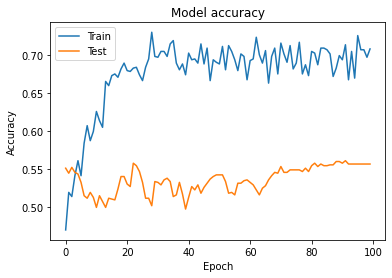

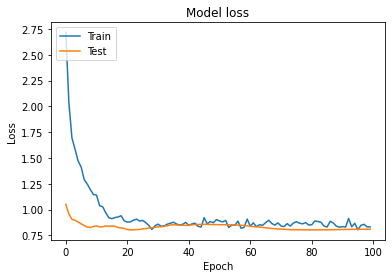

In [43]:
##history = model.fit(x_train, y_train, validation_split=0.25, epochs=42, verbose=1)
##print(history.history)
#
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()